# File is adapted from CS 3511 HW06
Runtime analysis was adapted to also include Karatsuba (which I implemented myself).

In [1]:
import cmath # complex math
import math

def fft(A, w):
    """converts between the value and coefficient representations of A"""
    # assumes n is a power of 2
    n = len(A)

    # base case
    if n == 1:
        return A

    # split even and odd indices
    A_even = A[0::2]
    A_odd  = A[1::2]

    # recursive result
    y_even = fft(A_even, w**2)
    y_odd = fft(A_odd, w**2)

    # stores result
    y = [0] * n

    for j in range(n // 2):
        y[j] = y_even[j] + (w**j) * y_odd[j]
        y[j + n//2] = y_even[j] - (w**j) * y_odd[j]

    return y

In [2]:
def round_array(arr):
  """helper function to round the numbers in an array to 4 decimal places"""
  decimal_places = 4
  return [round(a.real, decimal_places) + round(a.imag, decimal_places) * 1j for a in arr]

# running FFT on the polynomial
# 1 + 2x + 3x² + 4x³ + 5x⁴ + 6x⁵ + 7x⁶ + 8x⁷
poly = [1, 2, 3, 4, 5, 6, 7, 8]

w = cmath.exp(2j * math.pi / len(poly))
values = fft(poly, w)
values = round_array(values)

print(values)

[(36+0j), (-4-9.6569j), (-4-4j), (-4-1.6569j), (-4+0j), (-4+1.6569j), (-4+4j), (-4+9.6569j)]


In [3]:
coeffs = fft(values, w**-1)
coeffs = [c/len(coeffs) for c in coeffs] # scales by 1/n
coeffs = round_array(coeffs)
print(coeffs)

[(1+0j), (2+0j), (3+0j), (4+0j), (5+0j), (6+0j), (7+0j), (8+0j)]


In [4]:
def multiply_polynomials_fft(A, B):
    """multiplies two polynomials A, B with integer coefficients"""

    # finds the next power of 2
    n = 1
    while n <= len(A) + len(B) - 1:
        n *= 2

    # pads A and B with 0s
    A += [0] * (n - len(A))
    B += [0] * (n - len(B))

    # get the values of A and B
    w = cmath.exp(2j * math.pi / n)
    A_values = fft(A, w)
    B_values = fft(B, w)

    # multiply the polynomials in the value representation
    C_values = [A_values[i] * B_values[i] for i in range(n)]

    # convert back to coefficient representation and normalize
    w_inv = w**-1
    C = fft(C_values, w_inv)
    C = [c/len(C) for c in C]

    # converts back to integers
    # and remove trailing zeros
    C = [round(c.real) for c in C]
    while C and C[-1] == 0: C.pop()
    return C

In [12]:
# multiply (1 + 2x + 3x²) and (4 + 5x + 6x²)
A = [1, 2, 3]
B = [4, 5, 6]

result = multiply_polynomials_fft(A, B)
print(result)

[4, 13, 28, 27, 18]


In [6]:
def multiply_polynomials_naive(A, B):
    """multiplies two polynomials A, B with integer coefficients"""
    n = (len(A) + len(B) - 1)
    C = [0] * n

    for i in range(len(A)):
        for j in range(len(B)):
            C[i + j] += A[i] * B[j]

    return C

In [64]:
A = [1, 2, 3]
B = [4, 5, 6]
# 1 * 10^0 + 2 * 10^1 + 3 * 10^2 = 321
# 4 * 10^0 + 5 * 10^1 + 6 * 10^2 = 654

result = multiply_polynomials_naive(A, B)
mult_result = sum([result[x] * 10**x for x in range(len(result))])
print(mult_result)

209934


In [65]:
def next_power_of_2(n):
    return 1 if n == 0 else 2**math.ceil(math.log2(n))

def pad_to_power_of_2(A, B):
    size = next_power_of_2(max(len(A), len(B)))
    A.extend([0] * (size - len(A)))
    B.extend([0] * (size - len(B)))
    return A, B

def multiply_poly_karatsuba(A, B):
    A, B = pad_to_power_of_2(A, B)
    A = A[::-1]
    B = B[::-1]
    return multiply_karatsuba(A, B)

def multiply_karatsuba(A, B) -> int:
    # We want left numbers to be of higher power
    if len(A) == 1 and len(B) == 1:
        return A[0] * B[0]
    
    m = int(len(A)/2)

    A_l = A[:m]
    A_r = A[m:]

    B_l = B[:m]
    B_r = B[m:]

    P_1 = multiply_karatsuba(A_l, B_l)
    P_2 = multiply_karatsuba(A_r, B_r)

    A_l_plus_r = [A_l[x] + A_r[x] for x in range(len(A_l))]
    B_l_plus_r = [B_l[x] + B_r[x] for x in range(len(B_l))]
    P_3 = multiply_karatsuba(A_l_plus_r, B_l_plus_r)
    

    return P_1 * 10**(2*m) + (P_3 - P_1 - P_2) * 10**m + P_2

In [66]:
A = [1, 2, 1]
B = [9, 1, 1, 1]

result = multiply_poly_karatsuba(A, B)
print(result)

135399


### We're going to test your two implementations against eachother 🤯. The below code runs a bunch of experiments of FFT polynomial multiplication versus the naive polynomial multiplication, and then calculates the time each one takes. It shows both a logarithmic scaled plot (easier to see the intersection) and a linearly scaled plot (easier to see the runtime gap)

### This may take a while (~1 min) to run. After it runs, take a screenshot of the graph you generated and upload it into your homework PDF.

Running polynomial multiplication tests: 100%|██████████| 223696200/223696200 [00:31<00:00, 7006310.07it/s]


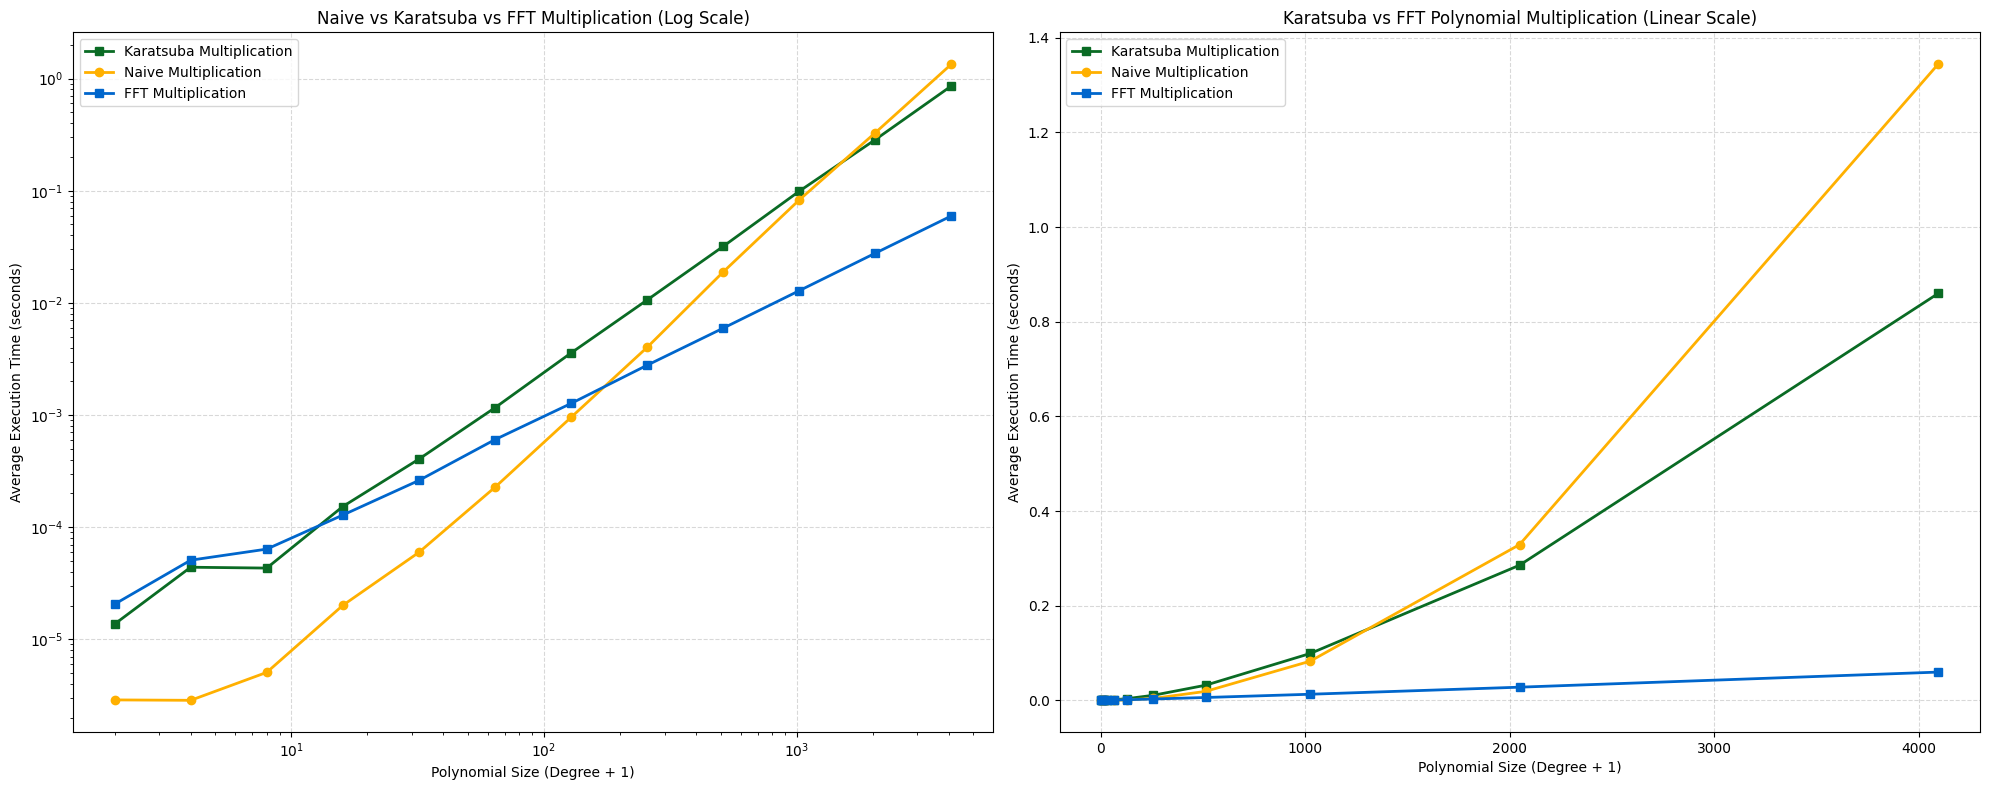

In [60]:
""" NO CHANGES NECESSARY BELOW """

import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

def measure_time(func, *args):
    start_time = time.time()
    func(*args)
    return time.time() - start_time

sizes = [2**i for i in range(1, 13)]
naive_times = []
fft_times = []
karatsuba_times = []

num_runs = 10

weights = [size**2 for size in sizes]
total_work = sum(weights) * num_runs

with tqdm(total=total_work, desc="Running polynomial multiplication tests") as pbar:
    for size, weight in zip(sizes, weights):
        size_naive_times = []
        size_fft_times = []
        size_karatsuba_times = []

        for _ in range(num_runs):
            A = [random.randint(0, 10) for _ in range(size)]
            B = [random.randint(0, 10) for _ in range(size)]

            naive_time = measure_time(multiply_polynomials_naive, A, B)
            fft_time = measure_time(multiply_polynomials_fft, A, B)
            karatsuba_time = measure_time(multiply_poly_karatsuba, A, B)

            size_karatsuba_times.append(karatsuba_time)
            size_fft_times.append(fft_time)
            size_naive_times.append(naive_time)

            pbar.update(weight)

        karatsuba_times.append(np.mean(size_karatsuba_times))
        naive_times.append(np.mean(size_naive_times))
        fft_times.append(np.mean(size_fft_times))

plt.style.use('default')
fig = plt.figure(figsize=(20, 8))
fig.patch.set_facecolor('white')


naive_color = '#FFB000'
karatsuba_color = '#0a6b24'
fft_color = '#0066CC'

# log plot
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax1.set_facecolor('white')
plt.plot(sizes, karatsuba_times, label="Karatsuba Multiplication", marker="s", color=karatsuba_color, linewidth=2)
plt.plot(sizes, naive_times, label="Naive Multiplication", marker="o", color=naive_color, linewidth=2)
plt.plot(sizes, fft_times, label="FFT Multiplication", marker="s", color=fft_color, linewidth=2)
plt.xlabel("Polynomial Size (Degree + 1)")
plt.ylabel("Average Execution Time (seconds)")
plt.title("Naive vs Karatsuba vs FFT Multiplication (Log Scale)")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.grid(True, color='gray', linestyle='--', alpha=0.3)

# linear plot
plt.subplot(1, 2, 2)
ax2 = plt.gca()
ax2.set_facecolor('white')
plt.plot(sizes, karatsuba_times, label="Karatsuba Multiplication", marker="s", color=karatsuba_color, linewidth=2)
plt.plot(sizes, naive_times, label="Naive Multiplication", marker="o", color=naive_color, linewidth=2)
plt.plot(sizes, fft_times, label="FFT Multiplication", marker="s", color=fft_color, linewidth=2)
plt.xlabel("Polynomial Size (Degree + 1)")
plt.ylabel("Average Execution Time (seconds)")
plt.title("Karatsuba vs FFT Polynomial Multiplication (Linear Scale)")
plt.legend()
plt.grid(True, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

### **Isn't that cool! Please remember to include the curves above as well as your FFT multiplication code in your submission that will be uploaded to Gradescope. You will not need to submit this notebook.**

In [9]:
%pip install matplotlib
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
